# In welchen Berufen arbeiten die Visa Bewerber?

In [1]:
import cleanup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import modules
import numpy as np
plt.style.use('../own_style.mplstyle')

In [2]:
# cleanup.generate_cleaned_df()


In [3]:

col_list = [ "pw_job_title_9089"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

In [4]:
modules.print_full(visas_df['pw_job_title_9089'].value_counts()[:30])

software developers, application                105314
computer systems analyst                         35392
software developers, systems software            20234
electronics engineers, except computer           12450
computer and information systems manager          8907
accountants and auditor                           5238
mechanical engineer                               5058
computer software engineers, application          4902
marketing manager                                 4192
management analyst                                4120
database administrator                            4053
financial analyst                                 3974
electrical engineer                               3685
internists, general                               3608
network and computer systems administrator        3541
statistician                                      3306
industrial engineer                               2995
financial manager                                 2988
software d

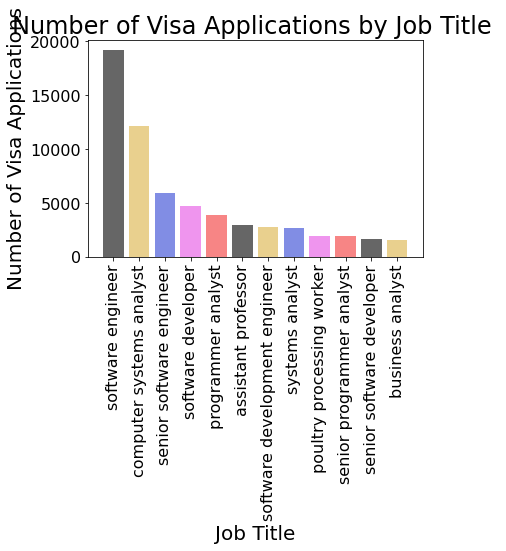

In [5]:

fig, ax = plt.subplots()

JobTitle = ('software engineer', 'computer systems analyst', 'senior software engineer', 'software developer', 'programmer analyst', 'assistant professor', 'software development engineer', 'systems analyst', 'poultry processing worker', 'senior programmer analyst', 'senior software developer', 'business analyst')
NumberofVisaApplications = [19211, 12138, 5978, 4721, 3918, 2952, 2814, 2670, 1989, 1930, 1671, 1593]
y_pos = np.arange(len(JobTitle))
couleur = ['#000000', '#dbb243', '#2e42d3', '#e54fe3', '#f23434']
plt.title('Number of Visa Applications by Job Title ')
plt.ylabel('Number of Visa Applications')
plt.xlabel("Job Title")
plt.bar(y_pos, NumberofVisaApplications, align='center', alpha=0.6, color=couleur)
ax.set_xticks(range(len(JobTitle)))
ax.set_xticklabels(JobTitle, rotation='vertical')
plt.show()
#plt.savefig('Number of Visa Applications by Job Title.png')

In [6]:
visas_df['pw_job_title_9089'] = visas_df['pw_job_title_9089'].astype(str).str.split(',').str[0]

<AxesSubplot:title={'center':'Number of Visa Applications by Job Title'}, xlabel='Job Title', ylabel='Number of Visa Applications'>

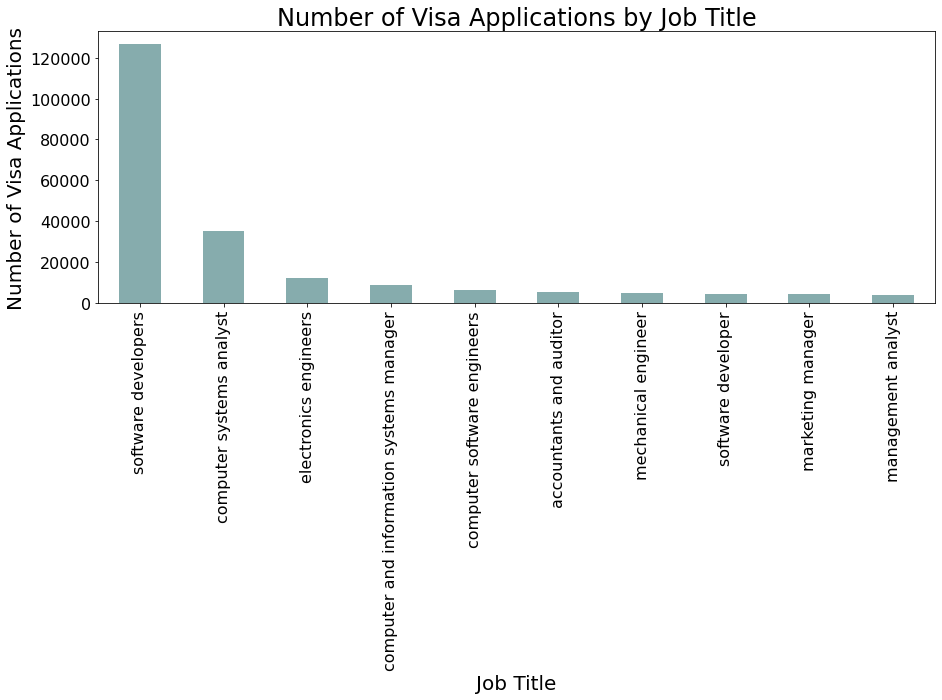

In [10]:
visas_df['pw_job_title_9089'].value_counts()[:10].plot(kind="bar", xlabel="Job Title", ylabel = "Number of Visa Applications", title = "Number of Visa Applications by Job Title", figsize = [15,5])


In [8]:
visas_df['pw_job_title_9089'].value_counts()[:10]
#TODO Graphen überarbeiten
#TODO: Anzahl einfügen

software developers                         126601
computer systems analyst                     35396
electronics engineers                        12494
computer and information systems manager      8907
computer software engineers                   6254
accountants and auditor                       5238
mechanical engineer                           5059
software developer                            4517
marketing manager                             4193
management analyst                            4121
Name: pw_job_title_9089, dtype: int64